<a href="https://colab.research.google.com/github/fabriciosantana/mcdia/blob/main/01-icd/assignments/04-analise-tematica-discursos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classificação em temas dos Discursos do Senado


## Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import plotly.graph_objects as go
from plotly.colors import qualitative
from datasets import load_dataset
from datasets import DownloadMode
from datasets import Dataset
from datasets import load_dataset_builder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)



## Carregar dados

In [2]:
DATASET_HF_REPO = "fabriciosantana/discursos-senado-legislatura-56"
DATA_FILE_HF = {"train": "data/full/discursos_2019-02-01_2023-01-31.parquet"}
CACHE_DATASET_DIR = Path.home() / '.cache/huggingface/datasets'
CACHE_LOCAL = CACHE_DATASET_DIR / 'fabriciosantana___discursos-senado-legislatura-56'

try:
    dataset = load_dataset(
        DATASET_HF_REPO,
        data_files=DATA_FILE_HF,
        download_mode=DownloadMode.REUSE_DATASET_IF_EXISTS
    )
    df_raw = dataset['train'].to_pandas()
except Exception as err:
    print('Falha ao carregar diretamente do Hub. Usando cache local.', err)
    arrow_candidates = list(CACHE_LOCAL.glob('default-*/0.0.0/*/discursos-senado-legislatura-56-train.arrow'))
    if not arrow_candidates:
        raise
    ds_cache = Dataset.from_file(str(arrow_candidates[0]))
    df_raw = ds_cache.to_pandas()

df_raw.head()


,id,CodigoPronunciamento,Casa,Data,Resumo,Indexacao,TextoIntegral,TextoIntegralTxt,UrlTextoBinario,TipoAutor,...,Apartes.Aparteante,__janela_inicio,__janela_fim,CargoAutor,OrgaoAutor,PaisAutor,TextoDiscursoIntegral,ok,status,msg
0,451286,451286,Senado Federal,2019-02-27,Comentários a respeito da concentração bancári...,"COMENTARIO, CONCENTRAÇÃO, REDE BANCARIA, COBRA...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,SENADO FEDERAL SF -\nSECRETARIA-GERAL DA MESA\...,True,200,
1,451285,451285,Senado Federal,2019-02-27,Registro do impacto da reforma da previdência ...,"REGISTRO, REFORMA, PREVIDENCIA SOCIAL, ALTERAÇ...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,SENADO FEDERAL SF -\nSECRETARIA-GERAL DA MESA\...,True,200,
2,451205,451205,Senado Federal,2019-02-27,Comentários a respeito da catástrofe ocorrida ...,"COMENTARIO, DESASTRE, ROMPIMENTO, BARRAGEM, BR...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,O SR. WELLINGTON FAGUNDES (Bloco Parlamentar V...,True,200,
3,451203,451203,Senado Federal,2019-02-27,Expectativa com o início dos trabalhos no âmbi...,"EXPECTATIVA, INICIO, TRABALHO, COMISSÕES, SENA...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,O SR. CONFÚCIO MOURA (Bloco Parlamentar Unidos...,True,200,
4,451202,451202,Senado Federal,2019-02-27,Relato da origem e das motivações do Projeto d...,"COMENTARIO, ORIGEM, MOTIVO, PROJETO DE LEI, OB...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,O SR. RODRIGO PACHECO (Bloco Parlamentar Vangu...,True,200,


## Configurar stop words

In [3]:
stopwords_pt = """a ao aos as ate com como contra da das de dela dele deles delas dentro depois desde dessa desse desta deste disso do dos e ela elas ele eles em entre essa esse essas esses esta este estou eu foi ha isso ja la mais mas mesmo mesma mesmos mesmas meus minhas na nas nem no nos nossa nosso nossas nossos ou para pela pelas pelo pelos perante pois por porque qual quando que quem se sem ser sob sobre sua suas tambem também tem tendo tera teve todos todo toda todas um uma umas uns vai ver voce voces vocês não nao sim sempre ainda apoio agora aqui algo alguns algumas assunto assuntos brasil brasileiro brasileira brasileiros brasileiras bem boa boas bom bons cada casa colegas colega congresso Congresso Nacional claro colocar colocado colocar colocar-se colocar-nos coisa coisas continuar governo governador grande grandes gostaria gosto importante interesse justamente legislativo lei leis mantendo manter mesa mesmo mesmos muito muitas nosso nossa nossos nossas novo nova novos novas olha parte pautas palavra palavras pessoas pode poder podem podemos precisa precisa-se precisao presidente projeto projetos proprio própria propria próprias próprios publico pública publicos publicas respeito retorno senador senadora senadores senhor senhora senhoras senhores sessao sessão social trabalho tribuna verdade votar voto votos dizer disse falar falou queria quero quero dizer quero registrar agradecer agradecer agradecer quero destacar destacar destacar quero destacar quero parabenizar parabenizo parabens parabéns obrigado obrigada parabéns gostaria registrar registrar senhor presidente senhora presidente senhoras senhores portanto então entao aqui agora assim ali aliás também então entao temos ter ser serão sera serão somos estou estamos estavam estão esta está estão era eram foi fui foram seria seriam gostaria gostaria gostaria gostaria gostaria quero quero quero quero desejo
auto autora autores autor autoras sr sra dr dra exmo exma excelentissimo excelentíssima presidente presidentea presidencia presidência senador senadora senadores senadoras mesa plenário plenaria orador oradora nobre nobre colega colegas companheiro companheira companheiros companheiras
""".split()

stopwords_pt = sorted(set(stopwords_pt))
stopwords_pt_set = set(stopwords_pt)
len(stopwords_pt)


267

In [4]:
import re

pattern_parenteses = re.compile(r'\([^\)]{0,120}\)')
pattern_formal = re.compile(r'\b(?:sr|sra|dra|dr|presidente|presidencia|senador|senadora|senhores|senhoras|mesa|sessao|sessão|plenário|plenaria|orador|oradora|vice|excelencia|excelentissimo|meu|minha|nobre)\b', re.IGNORECASE)

def limpar_texto(texto: str) -> str:
    if not isinstance(texto, str):
        return ''
    texto = pattern_parenteses.sub(' ', texto)
    texto = re.sub(r'https?://\S+', ' ', texto)
    texto = texto.replace('\n', ' ')
    texto = re.sub(r'\b(?:o\s+sr\.?|a\s+sra\.?|sr\.?|sra\.?|dr\.?|dra\.?|exmo\.?|exma\.?)', ' ', texto, flags=re.IGNORECASE)
    texto = texto.lower()
    texto = pattern_formal.sub(' ', texto)
    texto = re.sub(r'[^a-zà-ÿ\s]', ' ', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    tokens = [tok for tok in texto.split() if tok not in stopwords_pt_set and len(tok) > 2]
    return ' '.join(tokens)


## Preparar dados para análise temática

Filtramos colunas relevantes, padronizamos o texto e removemos discursos muito curtos para reduzir ruído.


In [5]:
colunas = ['Data', 'NomeAutor', 'Partido', 'UF', 'TextoDiscursoIntegral']

df = (
    df_raw[colunas]
    .rename(columns={
        'TextoDiscursoIntegral': 'texto',
        'NomeAutor': 'nome_autor'
    })
    .dropna(subset=['texto'])
)

df['texto'] = df['texto'].str.strip()
df = df[df['texto'].str.len() > 0]
df['texto_original'] = df['texto']
df['texto_limpo'] = df['texto'].apply(limpar_texto)
df = df[df['texto_limpo'].str.len() > 0]
df['Data'] = pd.to_datetime(df['Data'], errors='coerce')
df = df.dropna(subset=['Data'])
df['n_palavras'] = df['texto_limpo'].str.split().str.len()
df = df[df['n_palavras'] >= 25]
df = df.sort_values('Data').reset_index(drop=True)

print(f"Discursos após limpeza: {len(df):,}")
df[['Data', 'nome_autor', 'Partido', 'texto_limpo']].head()


Discursos após limpeza: 13,821


,Data,nome_autor,Partido,texto_limpo
0,2019-02-01,Davi Alcolumbre,DEM,escutei atentamente ponderações nesta preparat...
1,2019-02-01,Davi Alcolumbre,DEM,encerrada votação kátia abreu presidir humbert...
2,2019-02-01,Davi Alcolumbre,DEM,passo responder questões ordem randolfe lasier...
3,2019-02-01,Major Olimpio,PSL,major olimpio contribuir debate manifesto ques...
4,2019-02-01,Weverton,PDT,weverton rocha agradeço exa prometo vou rápido...


## Selecionar amostra para acelerar modelagem

O conjunto é reduzido para acelerar a vetorização e a extração de temas sem perder representatividade temporal.


In [6]:
MAX_DISCURSOS = 6000

if len(df) > MAX_DISCURSOS:
    df_modelo = df.sample(MAX_DISCURSOS, random_state=42).sort_values('Data').reset_index(drop=True)
else:
    df_modelo = df.copy()

print(f'Tamanho final da amostra: {len(df_modelo):,}')

df_modelo['Data'].agg(['min', 'max'])


Tamanho final da amostra: 6,000


min   2019-02-01
max   2023-01-10
Name: Data, dtype: datetime64[ns]

## Realizar vetorização com TF-IDF

Transformamos os discursos em vetores de características, preservando unigramas e bigramas frequentes.


In [7]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=15000,
    min_df=5,
    max_df=0.9,
    ngram_range=(1, 2),
    token_pattern=r'(?u)\b[a-zà-ÿ]{3,}\b',
    stop_words=None,
    strip_accents='unicode'
)

tfidf_matrix = tfidf_vectorizer.fit_transform(df_modelo['texto_limpo'])

print('Dimensões da matriz TF-IDF:', tfidf_matrix.shape)


Dimensões da matriz TF-IDF: (6000, 15000)


## Descobrir temas com NMF

Aplicamos NMF (Non-negative Matrix Factorization) para captar padrões latentes de vocabulário que sugerem temas.


In [8]:
N_TEMAS = 12

nmf_model = NMF(
    n_components=N_TEMAS,
    random_state=42,
    init='nndsvda',
    max_iter=500
)

W = nmf_model.fit_transform(tfidf_matrix)
H = nmf_model.components_

print('Matriz W (documentos x temas):', W.shape)
print('Matriz H (temas x termos):', H.shape)


Matriz W (documentos x temas): (6000, 12)
Matriz H (temas x termos): (12, 15000)


## Analisar principais termos por tema

Listamos as palavras com maior peso em cada tema para auxiliar na interpretação semântica.


In [9]:
agenda_stopwords = stopwords_pt_set.union({
    'senado', 'federal', 'senador', 'senadora', 'senadores', 'senadoras',
    'brasil', 'brasileiro', 'brasileira', 'brasileiros', 'brasileiras',
    'art', 'artigo', 'artigos', 'lei', 'leis', 'mp', 'mpv', 'pl', 'plp', 'pec', 'lc',
    'camara', 'materia', 'materias', 'projeto', 'projetos', 'requerimento', 'requerimentos',
    'plenaria', 'plenario', 'sessao', 'sessao solene', 'solene', 'solenidade',
    'amazonas', 'roraima', 'amapa', 'para', 'maranhao', 'acre', 'tocantins', 'rondonia',
    'mato', 'grosso', 'goias', 'bahia', 'ceara', 'alagoas', 'pernambuco', 'piaui',
    'sergipe', 'paraiba', 'rio', 'janeiro', 'minas', 'gerais', 'parana', 'sao', 'paulo',
    'catarina', 'brasilia', 'distrito', 'sul', 'norte', 'nordeste', 'sudeste',
    'centro', 'oeste', 'jean', 'paul', 'prates', 'amin', 'esperidiao', 'marcio', 'bittar',
    'pacheco', 'colombo', 'ciro', 'nogueira', 'kajuru', 'alcolumbre', 'girão', 'rodrigo',
    'lira', 'artur', 'wellington', 'fagundes', 'weverton', 'barreto', 'major', 'olimpio',
    'jayme', 'campos', 'carlos', 'favaro', 'fernando', 'bezerra', 'viana', 'eduardo', 'girao',
    'paul prates', 'jean paul', 'mato grosso', 'grosso sul', 'distrito federal', 'senado federal',
    'santa catarina', 'supremo tribunal', 'paulo rocha', 'rocha', 'dario', 'berger', 'dario berger',
    'izalci', 'zelia', 'paulo rocha', 'jayme campos', 'carlos viana', 'fernando bezerra',
    'exa', 'gente', 'questao', 'questões', 'hoje', 'momento', 'tenho', 'sabe', 'inclusive',
    'vamos', 'realmente', 'vou', 'tudo', 'coisa', 'coisas', 'dia', 'dias', 'anos', 'ano',
    'agora', 'aqui', 'nos', 'voce', 'vocês', 'nossa', 'quero', 'queria', 'agradecer',
    'registrar', 'importante', 'homenagem', 'especial', 'presenca', 'comissao', 'comissões',
    'fazer', 'acho', 'tem', 'ate', 'quer', 'vezes', 'dar', 'nos vamos', 'vamos ver', 'sou', 'estar', 'mundo',
    'palavra', 'fala', 'falando', 'discurso', 'querido', 'amigo', 'nome'
})

filler_tokens = {
    'gente', 'questao', 'questões', 'hoje', 'momento', 'tenho', 'sabe', 'inclusive',
    'vamos', 'realmente', 'vou', 'tudo', 'coisa', 'coisas', 'dia', 'dias', 'anos', 'ano',
    'agora', 'aqui', 'nos', 'voce', 'vocês', 'nossa', 'quero', 'queria', 'agradecer',
    'registrar', 'importante', 'homenagem', 'especial', 'presenca', 'comissao', 'comissões',
    'fazer', 'acho', 'tem', 'ate', 'quer', 'vezes', 'dar', 'nos vamos', 'sou', 'estar', 'mundo',
    'palavra', 'fala', 'falando', 'discurso', 'querido', 'amigo', 'nome'
}

agenda_keywords = [
    (('vacina', 'covid', 'pandemi', 'saude', 'imuniza', 'sus'), 'Saúde e Vacinação'),
    (('previdencia', 'aposent', 'reforma'), 'Reforma da Previdência'),
    (('educacao', 'ensino', 'escola', 'universidade', 'professor', 'aluno', 'fundeb'), 'Educação'),
    (('mulher', 'femin', 'violencia', 'feminicidio'), 'Direitos das Mulheres'),
    (('amazoni', 'ambient', 'clima', 'desmat', 'indigen', 'sustent', 'energia'), 'Meio Ambiente e Amazônia'),
    (('supremo', 'judici', 'stf', 'tribunal', 'justica'), 'Judiciário e STF'),
    (('petrobras', 'combustivel', 'gasolina', 'diesel', 'petroleo', 'energia', 'preco', 'combustiveis'), 'Energia e Combustíveis'),
    (('agric', 'agro', 'safra', 'produtor', 'rural', 'agronegocio', 'campo', 'soja', 'pecuaria'), 'Agronegócio'),
    (('seguranca', 'crime', 'violencia', 'policia', 'band', 'militar'), 'Segurança Pública'),
    (('econom', 'tribut', 'orcament', 'impost', 'carga'), 'Economia e Orçamento'),
    (('infra', 'rodov', 'transporte', 'logist', 'ferrovia', 'aeroporto', 'portu'), 'Infraestrutura e Transporte'),
    (('cultura', 'turismo', 'evento', 'esporte'), 'Cultura e Turismo'),
    (('homenagem', 'solene', 'sessao', 'comemoracao', 'medalha'), 'Homenagens e Sessões Especiais'),
    (('medida provisoria', 'provisor'), 'Medidas Provisórias'),
    (('ordem', 'pauta', 'votacao', 'lider', 'relator'), 'Processo Legislativo')
]

def gerar_rotulo(tokens):
    tokens_cap = []
    for tok in tokens:
        tok_clean = tok.replace('_', ' ')
        tokens_cap.append(tok_clean.title())
    return ' / '.join(tokens_cap)

def mapear_agenda(termos):
    termos_norm = [termo.replace(' ', '') for termo in termos]
    for keywords, label in agenda_keywords:
        for termo_norm in termos_norm:
            if any(termo_norm.startswith(kw.replace(' ', '')) or kw.replace(' ', '') in termo_norm for kw in keywords):
                return label
    return None

def extrair_top_termos(modelo, feature_names, top_n=15):
    registros = []
    for idx, topic in enumerate(modelo.components_):
        top_indices = topic.argsort()[::-1]
        termos = []
        for i in top_indices:
            termo = feature_names[i]
            if termo in agenda_stopwords:
                continue
            if any(char.isdigit() for char in termo):
                continue
            if len(termo) <= 2:
                continue
            if termo.startswith('art') and len(termo) <= 5:
                continue
            termos.append(termo)
            if len(termos) >= top_n:
                break
        if not termos:
            termos = [feature_names[i] for i in top_indices[:top_n]]
        termos_unicos = []
        for termo in termos:
            if termo not in termos_unicos:
                termos_unicos.append(termo)
        agenda_label = mapear_agenda(termos_unicos)
        label_tokens = [t for t in termos_unicos if t not in filler_tokens][:3]
        if agenda_label:
            tema_label = agenda_label
        elif label_tokens:
            tema_label = gerar_rotulo(label_tokens)
        else:
            tema_label = 'Debates Gerais'
        registros.append({
            'tema_id': idx,
            'termos': termos_unicos,
            'tema_label': tema_label,
            'principais_termos': ', '.join(termos_unicos[:10])
        })
    return pd.DataFrame(registros)


In [10]:
feature_names = tfidf_vectorizer.get_feature_names_out()
temas_df = extrair_top_termos(nmf_model, feature_names)

banned_label_terms = {'wellington', 'esperidiao', 'jayme', 'carlos', 'fernando', 'izalci'}

def rotulo_agenda(termos, label_atual):
    termos_norm = [termo.replace(' ', '') for termo in termos]

    def contem(prefixos):
        return any(any(pref in termo_norm for pref in prefixos) for termo_norm in termos_norm)

    if contem(['vacina', 'covid', 'pandemi', 'saude', 'imuniza', 'sus']):
        return 'Saúde e Vacinação'
    if contem(['previdenc', 'aposent', 'reforma']):
        return 'Reforma da Previdência'
    if contem(['educa', 'ensino', 'escola', 'professor', 'aluno', 'fundeb', 'universi']):
        return 'Educação'
    if contem(['mulher', 'femin', 'violenc', 'feminicid']):
        return 'Direitos das Mulheres'
    if contem(['amazoni', 'ambient', 'clima', 'desmat', 'indigen', 'susten']):
        return 'Meio Ambiente e Amazônia'
    if contem(['supremo', 'judici', 'stf', 'tribunal', 'justica']):
        return 'Judiciário e STF'
    if contem(['petrobras', 'combustiv', 'gasolina', 'diesel', 'petroleo', 'energia', 'preco']):
        return 'Energia e Combustíveis'
    if contem(['agric', 'agro', 'safra', 'produtor', 'rural', 'agronegocio', 'pecuari', 'pantanal', 'cuiaba']):
        return 'Agronegócio'
    if contem(['seguranca', 'crime', 'polici', 'militar', 'homicid']):
        return 'Segurança Pública'
    if contem(['econom', 'tribut', 'orcament', 'impost', 'fiscal']):
        return 'Economia e Orçamento'
    if contem(['infra', 'rodov', 'transporte', 'logist', 'ferrovia', 'aeroport', 'portu']):
        return 'Infraestrutura e Transporte'
    if contem(['cultura', 'turismo', 'esporte', 'evento']):
        return 'Cultura e Turismo'
    if contem(['medidaprovisoria', 'provisor']):
        return 'Medidas Provisórias'
    if contem(['votacao', 'pauta', 'ordem', 'relator', 'lider', 'veto']):
        return 'Processo Legislativo'
    if contem(['homenag', 'solen', 'comemorac', 'medalh']):
        return 'Homenagens e Sessões Especiais'
    return label_atual if label_atual not in {'Debates Gerais', ''} else 'Debates Gerais'

def ajustar_label(row):
    label = rotulo_agenda(row['termos'], row['tema_label'])
    label_clean = label.lower()
    if any(term in label_clean for term in banned_label_terms):
        if any('votacao' in termo or 'ordem' in termo or 'relator' in termo or 'pauta' in termo for termo in row['termos']):
            return 'Processo Legislativo'
        if any('agric' in termo or 'agro' in termo or 'safra' in termo or 'rural' in termo for termo in row['termos']):
            return 'Agronegócio'
        return 'Debates Gerais'
    if label.startswith('Possa'):
        return 'Debates Gerais'
    return label

temas_df['tema_label'] = temas_df.apply(ajustar_label, axis=1)
temas_df[['tema_id', 'tema_label', 'principais_termos']]


,tema_id,tema_label,principais_termos
0,0,Debates Gerais,"possa, muita, sei, estava, tempo, forma, gente..."
1,1,Medidas Provisórias,"emenda, medida provisoria, provisoria, medida,..."
2,2,Segurança Pública,"nacional, convido, deputado, vida, deus, histo..."
3,3,Educação,"educacao, ensino, escola, escolas, professores..."
4,4,Meio Ambiente e Amazônia,"amazonia, estado, meio ambiente, energia, ambi..."
5,5,Judiciário e STF,"supremo, tribunal, tribunal federal, ministro,..."
6,6,Direitos das Mulheres,"mulheres, mulher, violencia, feminina, homens,..."
7,7,Saúde e Vacinação,"saude, vacina, vacinas, covid, pandemia, vacin..."
8,8,Reforma da Previdência,"reforma, previdencia, paim, paulo paim, pais, ..."
9,9,Energia e Combustíveis,"preco, petrobras, combustiveis, petroleo, dest..."


## Atribuir tema predominante aos discursos

Cada discurso recebe o tema com maior peso na decomposição, além da força relativa desse tema.


In [11]:
scores_df = pd.DataFrame(W, columns=[f'tema_{i}' for i in range(N_TEMAS)])

df_temas = df_modelo.reset_index(drop=True).join(scores_df)
df_temas['tema_id'] = scores_df.values.argmax(axis=1)
df_temas = df_temas.merge(temas_df[['tema_id', 'tema_label']], on='tema_id', how='left')

soma_scores = scores_df.sum(axis=1)
df_temas['forca_tema'] = scores_df.max(axis=1) / soma_scores.replace(0, np.nan)

df_temas[['Data', 'nome_autor', 'Partido', 'tema_label', 'forca_tema']].head()


,Data,nome_autor,Partido,tema_label,forca_tema
0,2019-02-01,Davi Alcolumbre,DEM,Segurança Pública,0.343525
1,2019-02-01,Juíza Selma,PSL,Medidas Provisórias,0.749916
2,2019-02-01,Randolfe Rodrigues,REDE,Medidas Provisórias,0.587700
3,2019-02-01,Eduardo Braga,MDB,Medidas Provisórias,0.492740
4,2019-02-01,Ciro Nogueira,PP,Judiciário e STF,0.800415


## Definir funções auxiliares para visualizações relacionais

Funções utilitárias para preparar fluxos e renderizar gráficos Sankey, reutilizadas nas análises a seguir.


In [12]:
def preparar_fluxo(df, origem, destino, top_origem=None, top_destino=None, min_fluxo=0):
    """Agrupa pares origem-destino e aplica filtros para reduzir ruído."""
    fluxo = (
        df.groupby([origem, destino])
          .size()
          .reset_index(name='n_discursos')
    )

    if top_origem is not None:
        top_vals = (
            fluxo.groupby(origem)['n_discursos']
                 .sum()
                 .nlargest(top_origem)
                 .index
        )
        fluxo = fluxo[fluxo[origem].isin(top_vals)]

    if top_destino is not None:
        top_vals_dest = (
            fluxo.groupby(destino)['n_discursos']
                 .sum()
                 .nlargest(top_destino)
                 .index
        )
        fluxo = fluxo[fluxo[destino].isin(top_vals_dest)]

    if min_fluxo:
        fluxo = fluxo[fluxo['n_discursos'] >= min_fluxo]

    return fluxo.sort_values('n_discursos', ascending=False)


def plotar_sankey(fluxo, origem, destino, valor='n_discursos', titulo=None, altura=600):
    """Plota gráfico Sankey com base no dataframe de fluxos preparado."""
    if fluxo.empty:
        raise ValueError('Fluxo vazio para plotar Sankey.')

    labels = []
    mapa = {}

    for label in fluxo[origem].unique():
        mapa[label] = len(labels)
        labels.append(label)

    for label in fluxo[destino].unique():
        if label not in mapa:
            mapa[label] = len(labels)
            labels.append(label)

    sources = fluxo[origem].map(mapa)
    targets = fluxo[destino].map(mapa)
    values = fluxo[valor]

    palette = qualitative.Plotly
    node_colors = [palette[i % len(palette)] for i in range(len(labels))]

    fig = go.Figure(go.Sankey(
        node=dict(
            pad=16,
            thickness=16,
            line=dict(color='rgba(0,0,0,0.2)', width=0.5),
            label=labels,
            color=node_colors
        ),
        link=dict(source=sources, target=targets, value=values)
    ))

    fig.update_layout(title=titulo, font=dict(size=12), height=altura)
    fig.show()

    return fluxo


## Analisar distribuição geral de temas

Observamos quais temas aparecem com maior frequência na amostra de discursos.


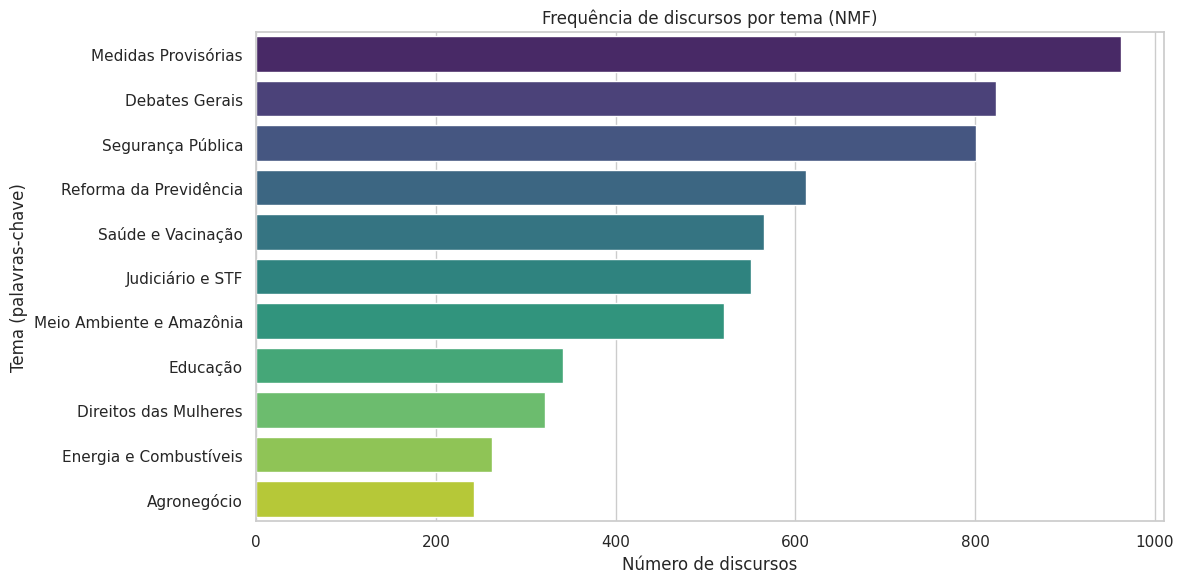

,tema_label,n_discursos
0,Medidas Provisórias,962
1,Debates Gerais,823
2,Segurança Pública,801
3,Reforma da Previdência,612
4,Saúde e Vacinação,565
5,Judiciário e STF,550
6,Meio Ambiente e Amazônia,521
7,Educação,341
8,Direitos das Mulheres,321
9,Energia e Combustíveis,262


In [13]:
contagem_temas = (
    df_temas['tema_label']
        .value_counts()
        .rename_axis('tema_label')
        .reset_index(name='n_discursos')
)

plt.figure(figsize=(12, 6))
sns.barplot(data=contagem_temas, x='n_discursos', y='tema_label', hue='tema_label', palette='viridis', legend=False)
plt.title('Frequência de discursos por tema (NMF)')
plt.xlabel('Número de discursos')
plt.ylabel('Tema (palavras-chave)')
plt.tight_layout()
plt.show()

contagem_temas


## Analisar evolução temporal do interesse por tema

Acompanhamos como a participação relativa de cada tema varia mês a mês.


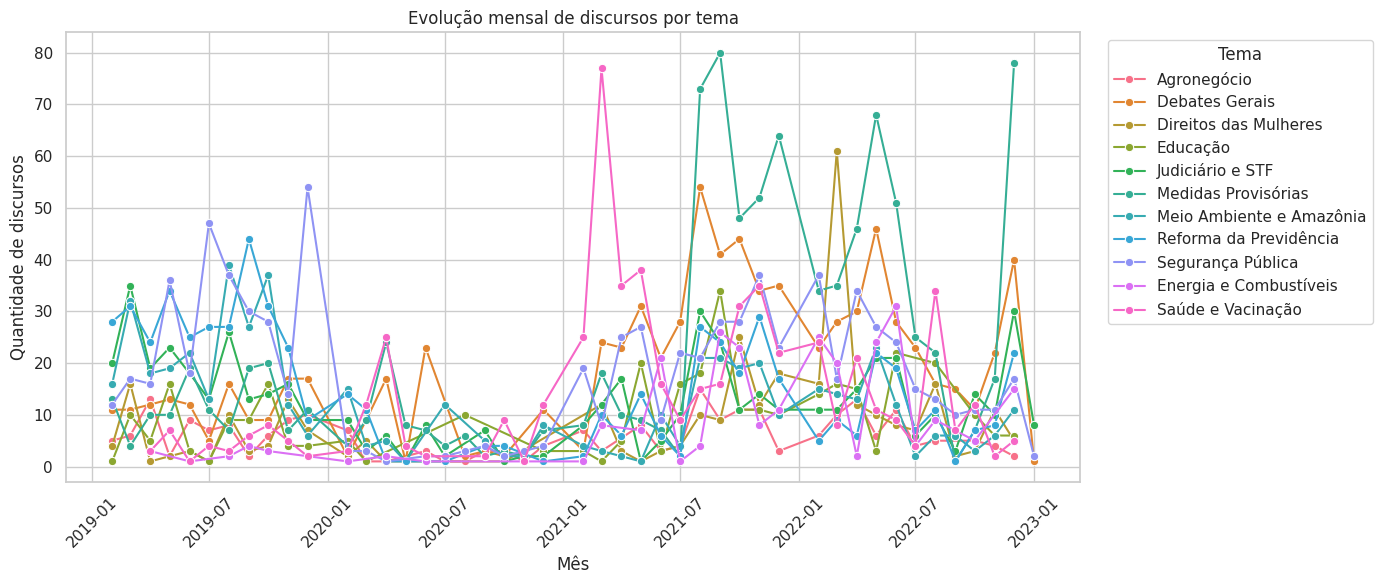

,mes,tema_label,n_discursos
0,2019-02-01,Agronegócio,5
1,2019-02-01,Debates Gerais,11
2,2019-02-01,Direitos das Mulheres,4
3,2019-02-01,Educação,1
4,2019-02-01,Judiciário e STF,20


In [14]:
df_temas['mes'] = df_temas['Data'].dt.to_period('M').dt.to_timestamp()
serie_temas = (
    df_temas.groupby(['mes', 'tema_label'])
        .size()
        .reset_index(name='n_discursos')
)

plt.figure(figsize=(14, 6))
sns.lineplot(data=serie_temas, x='mes', y='n_discursos', hue='tema_label', marker='o')
plt.title('Evolução mensal de discursos por tema')
plt.xlabel('Mês')
plt.ylabel('Quantidade de discursos')
plt.xticks(rotation=45)
plt.legend(title='Tema', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

serie_temas.head()


## Analisar participação percentual dos temas

Analisamos a participação relativa de cada tema em relação ao total de discursos do mês para identificar mudanças de prioridade ao longo do tempo.


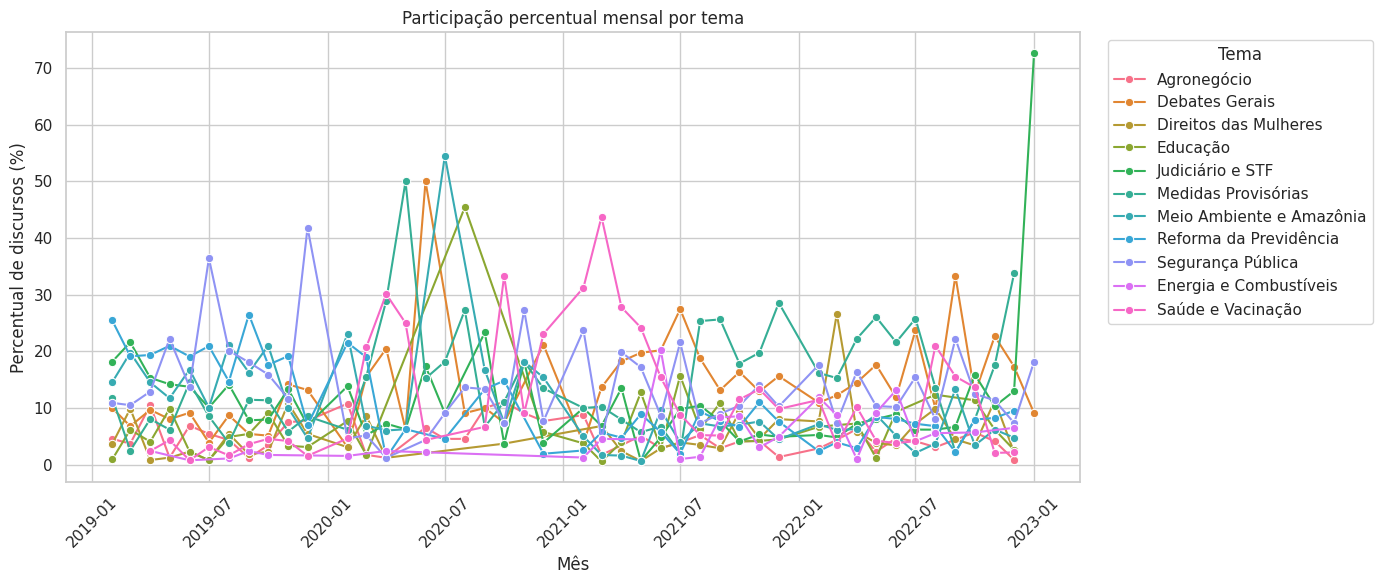

,mes,tema_label,n_discursos,total_mes,percentual
0,2019-02-01,Agronegócio,5,110,4.545455
1,2019-02-01,Debates Gerais,11,110,10.000000
2,2019-02-01,Direitos das Mulheres,4,110,3.636364
3,2019-02-01,Educação,1,110,0.909091
4,2019-02-01,Judiciário e STF,20,110,18.181818


In [15]:
serie_percentual = (
    serie_temas
        .assign(total_mes=lambda df: df.groupby('mes')['n_discursos'].transform('sum'))
        .assign(percentual=lambda df: (df['n_discursos'] / df['total_mes']) * 100)
)

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=serie_percentual,
    x='mes',
    y='percentual',
    hue='tema_label',
    marker='o'
)
plt.title('Participação percentual mensal por tema')
plt.xlabel('Mês')
plt.ylabel('Percentual de discursos (%)')
plt.xticks(rotation=45)
plt.legend(title='Tema', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

serie_percentual.head()


## Analisar percentual de discursos por tema e por mês

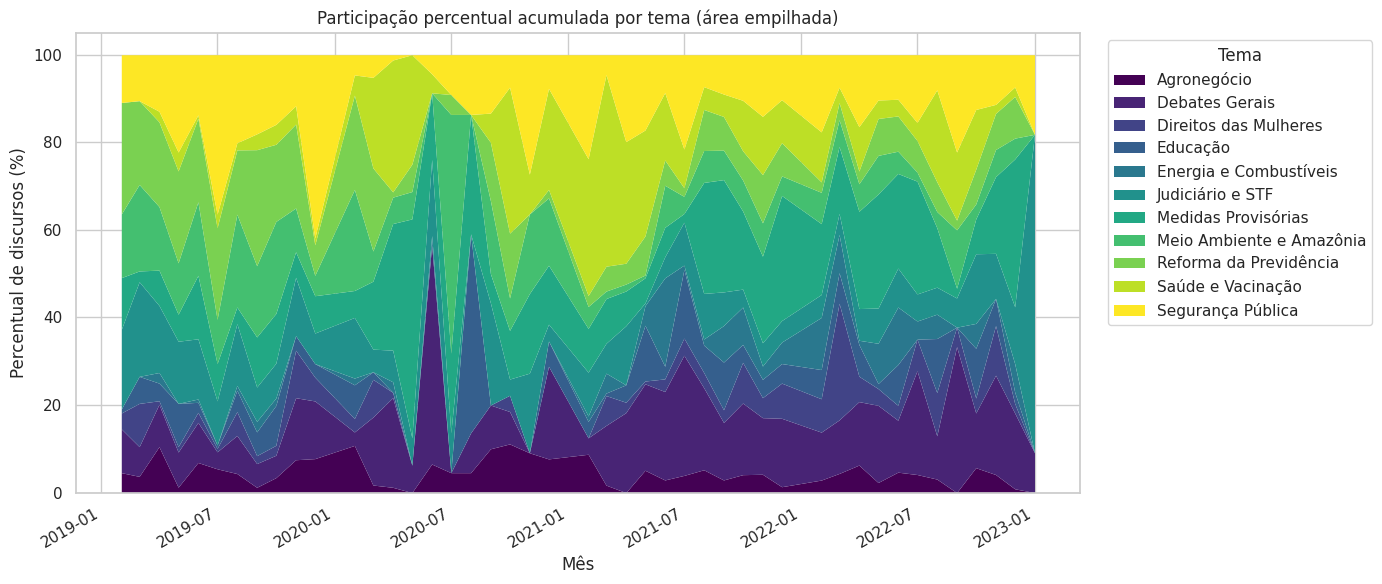

tema_label,Agronegócio,Debates Gerais,Direitos das Mulheres,Educação,Energia e Combustíveis,Judiciário e STF,Medidas Provisórias,Meio Ambiente e Amazônia,Reforma da Previdência,Saúde e Vacinação,Segurança Pública
mes,,,,,,,,,,,
2022-09-01,0.000000,33.333333,4.444444,0.000000,0.000000,6.666667,2.222222,13.333333,2.222222,15.555556,22.222222
2022-10-01,5.681818,12.500000,3.409091,11.363636,5.681818,15.909091,7.954545,3.409091,7.954545,13.636364,12.500000
2022-11-01,4.123711,22.680412,11.340206,6.185567,0.000000,10.309278,17.525773,6.185567,8.247423,2.061856,11.340206
2022-12-01,0.865801,17.316017,2.164502,2.597403,6.493506,12.987013,33.766234,4.761905,9.523810,2.164502,7.359307
2023-01-01,0.000000,9.090909,0.000000,0.000000,0.000000,72.727273,0.000000,0.000000,0.000000,0.000000,18.181818


In [16]:
serie_area = (
    serie_percentual
        .pivot(index='mes', columns='tema_label', values='percentual')
        .fillna(0)
        .sort_index()
)

ax = serie_area.plot.area(figsize=(14, 6), cmap='viridis', linewidth=0)
ax.set_title('Participação percentual acumulada por tema (área empilhada)')
ax.set_xlabel('Mês')
ax.set_ylabel('Percentual de discursos (%)')
ax.legend(title='Tema', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

serie_area.tail()


## Analisar tema predominante por mês

A tabela abaixo destaca qual tema liderou o volume de discursos em cada mês e a respectiva participação percentual.


In [17]:
tema_lider_mes = (
    serie_percentual
        .sort_values(['mes', 'percentual'], ascending=[True, False])
        .groupby('mes', as_index=False)
        .first()[['mes', 'tema_label', 'percentual']]
)

tema_lider_mes.head(12)


,mes,tema_label,percentual
0,2019-02-01,Reforma da Previdência,25.454545
1,2019-03-01,Judiciário e STF,21.604938
2,2019-04-01,Reforma da Previdência,19.354839
3,2019-05-01,Segurança Pública,22.222222
4,2019-06-01,Reforma da Previdência,19.083969
5,2019-07-01,Segurança Pública,36.434109
6,2019-08-01,Meio Ambiente e Amazônia,21.195652
7,2019-09-01,Reforma da Previdência,26.506024
8,2019-10-01,Meio Ambiente e Amazônia,21.022727
9,2019-11-01,Reforma da Previdência,19.166667


## Analisar conexões entre atores e temas

Exploramos relações entre senadores, partidos, unidades da federação e os temas inferidos para identificar redes de afinidade temática.


### Senadores e temas

Fluxos destacam os senadores mais prolíficos e os temas com os quais mais contribuem.


In [18]:
fluxo_senadores = preparar_fluxo(
    df_temas,
    origem='nome_autor',
    destino='tema_label',
    top_origem=18,
    top_destino=8,
    min_fluxo=15
)

fluxo_senadores_top = plotar_sankey(
    fluxo_senadores,
    origem='nome_autor',
    destino='tema_label',
    titulo='Relação entre senadores e temas predominantes'
)

fluxo_senadores_top.head(10)


,nome_autor,tema_label,n_discursos
432,Esperidião Amin,Debates Gerais,143
1210,Paulo Paim,Reforma da Previdência,128
733,Jean-Paul Prates,Energia e Combustíveis,78
1382,Rodrigo Pacheco,Medidas Provisórias,78
747,Jorge Kajuru,Judiciário e STF,77
393,Eduardo Girão,Judiciário e STF,73
648,Izalci Lucas,Segurança Pública,69
1386,Rodrigo Pacheco,Segurança Pública,64
389,Eduardo Girão,Debates Gerais,62
644,Izalci Lucas,Medidas Provisórias,58


### Partidos e temas

Mostra como cada legenda concentra seu discurso em determinados assuntos.


In [19]:
fluxo_partidos = preparar_fluxo(
    df_temas,
    origem='Partido',
    destino='tema_label',
    top_origem=12,
    top_destino=8,
    min_fluxo=25
)

fluxo_partidos_top = plotar_sankey(
    fluxo_partidos,
    origem='Partido',
    destino='tema_label',
    titulo='Relação entre partidos e temas predominantes'
)

fluxo_partidos_top.head(10)


,Partido,tema_label,n_discursos
87,PODEMOS,Judiciário e STF,199
184,PT,Reforma da Previdência,194
94,PP,Debates Gerais,172
31,MDB,Medidas Provisórias,168
147,PSD,Medidas Provisórias,135
151,PSD,Segurança Pública,93
83,PODEMOS,Debates Gerais,91
158,PSDB,Medidas Provisórias,90
88,PODEMOS,Medidas Provisórias,89
162,PSDB,Segurança Pública,87


### Unidades da federação e temas

A análise revela quais temas dominam a pauta dos senadores de cada estado.


In [20]:
fluxo_uf = preparar_fluxo(
    df_temas,
    origem='UF',
    destino='tema_label',
    top_origem=12,
    top_destino=8,
    min_fluxo=20
)

fluxo_uf_top = plotar_sankey(
    fluxo_uf,
    origem='UF',
    destino='tema_label',
    titulo='Relação entre unidades da federação e temas'
)

fluxo_uf_top.head(10)


,UF,tema_label,n_discursos
246,SC,Debates Gerais,159
242,RS,Reforma da Previdência,139
127,MT,Agronegócio,122
111,MG,Medidas Provisórias,116
71,DF,Segurança Pública,99
115,MG,Segurança Pública,85
88,GO,Judiciário e STF,84
55,CE,Judiciário e STF,74
67,DF,Medidas Provisórias,70
51,CE,Debates Gerais,67


### Matriz de intensidade partido × tema

A matriz complementar permite comparar a distribuição percentual dos discursos entre partidos e temas.


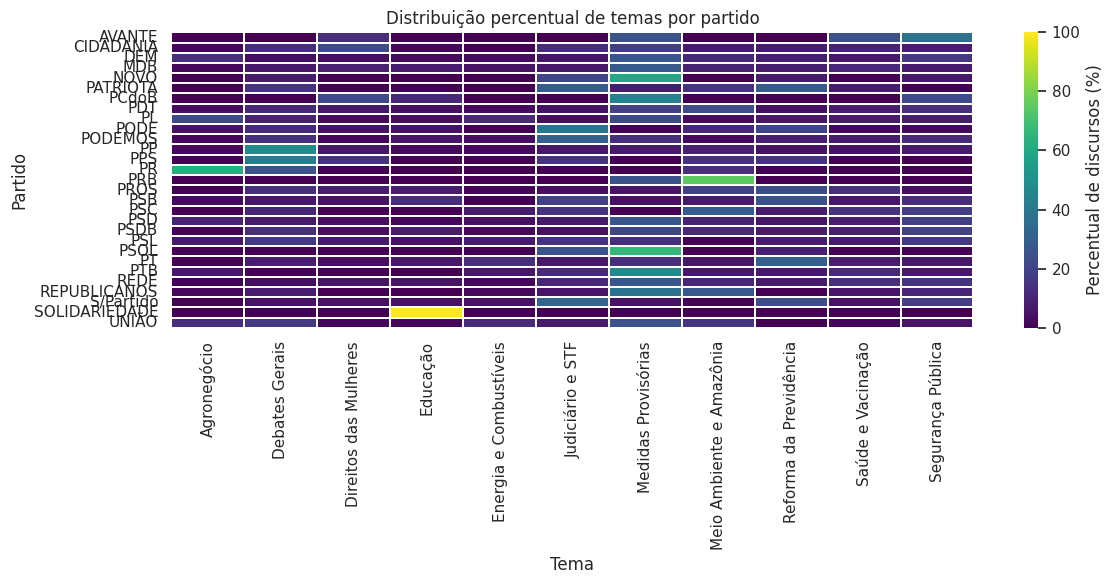

tema_label,Agronegócio,Debates Gerais,Direitos das Mulheres,Educação,Energia e Combustíveis,Judiciário e STF,Medidas Provisórias,Meio Ambiente e Amazônia,Reforma da Previdência,Saúde e Vacinação,Segurança Pública
Partido,,,,,,,,,,,
AVANTE,0.0,0.0,12.5,0.0,0.0,0.0,25.0,0.0,0.0,25.0,37.5
CIDADANIA,1.4,12.9,22.4,1.9,0.0,12.4,17.6,6.7,7.6,9.5,7.6
DEM,13.7,3.4,3.4,2.4,2.7,5.8,26.7,11.0,8.2,6.2,16.4
MDB,2.0,6.3,9.1,7.7,4.9,5.9,27.7,9.7,8.6,11.4,6.8
NOVO,0.0,6.7,0.0,0.0,0.0,20.0,60.0,0.0,6.7,0.0,6.7


In [21]:
matriz_partido_tema = (
    df_temas.groupby(['Partido', 'tema_label'])
        .size()
        .unstack(fill_value=0)
)

matriz_partido_tema_pct = matriz_partido_tema.div(matriz_partido_tema.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 6))
sns.heatmap(matriz_partido_tema_pct, cmap='viridis', linewidths=0.1, cbar_kws={'label': 'Percentual de discursos (%)'})
plt.title('Distribuição percentual de temas por partido')
plt.xlabel('Tema')
plt.ylabel('Partido')
plt.tight_layout()
plt.show()

matriz_partido_tema_pct.round(1).head()
